# City of Philadelphia Licenses and Inspections Appeals <a id='top'></a>

The dataset contains decisions of Philadelphia Licenses and Inspections Appeal Board. The dataset contains daily updates  in 37 columns.

Several columns such as Appeal Grounds, Related Permits and Proviso are in Natural Language format. 

Source: https://www.opendataphilly.org/dataset/license-and-inspections-appeals/resource/b721ad52-9e27-46d2-b494-6bf0ef1c7603?inner_span=True

### I would like to research the relationship of the board decision stored in the column 'decision' and other values in the dataset such as Appeal Grounds(NL), Related Permits(NL), Proviso(NL) and well as property address(geospatial).


## Table of Content

[Load and review the data](#Load-and-review-the-data)  
[Loading necessary packages](#Loading-necessary-packages)  
[Clear out Null values](#Clear-out-Null-values)  
[Remove /PROV value from decision column and store it as a flag in a separate field](#Remove-/PROV-value-from-decision-column-and-store-it-as-a-flag-in-a-separate-field)  
[Translate appeal decision into new feature and reduce the number of outcomes](#Translate-appeal-decision-into-new-feature-and-reduce-the-number-of-outcomes)  
[Dataset Centroids and distances from them](#Dataset-Centroids-and-distances-from-them)  
[Distances from Landmarks](#Distances-from-Landmarks)  
[Scatter Plot Map](#Scatter-Plot-Map)  
[Appeal Grounds](#Appeal-Grounds)  
[myMetrics Function for model testing](#myMetrics-Function-for-model-testing)  
[Pre-processing and Test/Train Split](#Pre-processing-and-Test/Train-Split)  
[Final Hypertable](#Final-Hypertable)  
[Testing Models with TFIDF classifier results](#Testing-Models-with-TFIDF-classifier-results)

### Loading necessary packages  <a id='Loading-necessary-packages'></a>

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
from pandas_profiling import ProfileReport
import string

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics #metrics module

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

hypertable=[]

### Load and review the data <a id='Load-and-review-the-data'></a> 
[(back to the top)](#top)

In [2]:
#Database URL
url = 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+appeals&filename=appeals&format=csv&skipfields=cartodb_id'
#Initial Dataset load
df = pd.read_csv(url, low_memory=False)

In [3]:
#Sample data
df.head()

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
0,0101000020E6100000AF9F68DBCDCB52C09FA1095A7B06...,0101000020110F00004C85746155ED5FC1A74786F21597...,19,310443.0,6643 GERMANTOWN AVE,NaN,NaN,19119-2253,871528220.0,424826,...,2009-12-09 14:00:00,GRANTED/PROV,NaN,**Proviso - letter from East Mount Airy Associ...,2009-12-09 00:00:00,HANSEN,2.686631e+06,271736.630322,40.050639,-75.184440
1,0101000020E6100000C622E4E4AAC752C012749513E2FF...,0101000020110F0000E62423A04EE65FC19120F964C48F...,20,608597.0,523 E WESTMORELAND ST,NaN,NaN,19134-1735,871513340.0,296064,...,2009-12-09 14:00:00,GRANTED/PROV,NaN,***Proviso - signs approved by Art Commission,2009-12-09 00:00:00,HANSEN,2.705277e+06,253497.440113,39.999087,-75.119806
2,0101000020E610000004ABEC4F5FC952C000CA443988F8...,0101000020110F0000F3B0F3EC33E95FC16889C4EB9E87...,21,398975.0,200-10 LOMBARD ST,NaN,NaN,19147-1613,NaN,423779,...,2009-10-28 14:00:00,GRANTED,NaN,NaN,2009-10-28 00:00:00,HANSEN,2.698434e+06,232364.846752,39.941657,-75.146442
3,0101000020E6100000769EB347BCCA52C0F60B249009F5...,0101000020110F00002657C2AE84EB5FC1F9E9E911C083...,22,655689.0,2823 S 12TH ST,NaN,NaN,19148-4906,395317600.0,167506,...,2009-10-28 14:00:00,GRANTED,NaN,NaN,2009-10-28 00:00:00,HANSEN,2.692755e+06,222247.826051,39.914354,-75.167742
4,0101000020E6100000962D644E58CA52C06545FD0B9F03...,0101000020110F00000D37F2DDDAEA5FC1D4BF7395E993...,23,309998.0,4827 GERMANTOWN AVE,NaN,NaN,19144-3014,884351670.0,21219,...,2009-10-08 14:10:00,APPROVED,NaN,NaN,2009-10-29 00:00:00,HANSEN,2.693250e+06,263785.290578,40.028291,-75.161640


In [4]:
#Number of rows and features
print("df.shape", df.shape)

df.shape (29884, 37)


In [5]:
#Column Names
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng'],
      dtype='object')

In [6]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29884 entries, 0 to 29883
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              29281 non-null  object 
 1   the_geom_webmercator  29281 non-null  object 
 2   objectid              29884 non-null  int64  
 3   addressobjectid       29306 non-null  float64
 4   address               29305 non-null  object 
 5   unit_type             105 non-null    object 
 6   unit_num              558 non-null    object 
 7   zip                   29305 non-null  object 
 8   opa_account_num       28154 non-null  float64
 9   parcel_id_num         28635 non-null  object 
 10  censustract           29281 non-null  float64
 11  opa_owner             28827 non-null  object 
 12  primaryappellant      29884 non-null  object 
 13  appellanttype         29047 non-null  object 
 14  internaljobid         27715 non-null  float64
 15  appealnumber       

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### Clear out Null values <a id='Clear-out-Null-values'></a>
[(back to the top)](#top)

I am dropping records with Null value in Decision column. They represent less than 10% of the data. With the multitude of unique values in that column I can't decide what value I can replace it with.

In [7]:
df = df[~df['decision'].isna()]
df[df['systemofrecord'].isna()]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [8]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

In [9]:
df[df['lat'].isna()].shape[0]

14

I'm dropping these as well.

In [10]:
df = df[~df['lat'].isna()]

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

In [11]:
#Percent of unique values per values per column
df.nunique()/df.shape[0]

the_geom                0.801161
the_geom_webmercator    0.801161
objectid                1.000000
addressobjectid         0.816843
address                 0.804576
unit_type               0.000184
unit_num                0.004297
zip                     0.486007
opa_account_num         0.775305
parcel_id_num           0.771779
censustract             0.014030
opa_owner               0.705964
primaryappellant        0.456919
appellanttype           0.000294
internaljobid           0.969260
appealnumber            1.000000
acceleratedappeal       0.000073
createddate             0.998604
completeddate           0.447297
relatedpermit           0.980425
relatedcasefile         0.000294
appealstatus            0.000294
appealtype              0.000477
agendadescription       0.000073
applicationtype         0.000257
meetingnumber           0.030740
appealgrounds           0.922616
scheduleddate           0.173865
decision                0.001175
meetingresult           0.000147
proviso   

In [12]:
df.dtypes

the_geom                 object
the_geom_webmercator     object
objectid                  int64
addressobjectid         float64
address                  object
unit_type                object
unit_num                 object
zip                      object
opa_account_num         float64
parcel_id_num            object
censustract             float64
opa_owner                object
primaryappellant         object
appellanttype            object
internaljobid           float64
appealnumber             object
acceleratedappeal        object
createddate              object
completeddate            object
relatedpermit            object
relatedcasefile          object
appealstatus             object
appealtype               object
agendadescription        object
applicationtype          object
meetingnumber            object
appealgrounds            object
scheduleddate            object
decision                 object
meetingresult            object
proviso                  object
decision

Clean Data Types

In [13]:
df['createddate'] = pd.to_datetime(df['createddate'])

In [14]:
df['completeddate'] = pd.to_datetime(df['completeddate'])
df['scheduleddate'] = pd.to_datetime(df['scheduleddate'])
df['decisiondate'] = pd.to_datetime(df['decisiondate'])

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

#### Cleaning  Application Type column

In [15]:
#Top examples of "applicationtype"
df['applicationtype'].value_counts().head(10)

RB_ZBA                         19042
RB_LIRB                         5587
RB_BBS                          1762
Zoning Board of Adjustment       783
Board of Building Standards       49
Plumbing Advisory Board            4
L&I Review Board Codes             1
Name: applicationtype, dtype: int64

Instead of using abbreviated values for Application Types lets rename them in fully spelled values

In [16]:
df['applicationtype'][df['applicationtype'] == 'RB_ZBA'] = 'Zoning Board of Adjustment'
df['applicationtype'][df['applicationtype'] == 'RB_LIRB'] = 'L&I Review Board Codes'
df['applicationtype'][df['applicationtype'] == 'RB_BBS'] = 'Board of Building Standards'

In [17]:
#Top examples of "appealgrounds"
df['applicationtype'].value_counts().head(10)

Zoning Board of Adjustment     19825
L&I Review Board Codes          5588
Board of Building Standards     1811
Plumbing Advisory Board            4
Name: applicationtype, dtype: int64

Lets drop Plumbing Advisory Board records as an outlier 

In [18]:
df = df[~(df['applicationtype'] == 'Plumbing Advisory Board')]

In [19]:
#Top examples of "appealgrounds"
df['applicationtype'].value_counts().head(10)

Zoning Board of Adjustment     19825
L&I Review Board Codes          5588
Board of Building Standards     1811
Name: applicationtype, dtype: int64

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

##### New Lawyer column showing if the owner is represented by a lawyer

In [20]:
df['primaryappellant'].value_counts().head(30)

SHAWN D. WARD, ESQUIRE          421
ZHEN JIN                        288
JOSEPH BELLER, ESQ.             254
DAVID ORPHANIDES, ESQ.          238
SHAWN WARD, ESQ.                228
RONALD PATTERSON, ESQ.          225
ALAN NOCHUMSON, ESQ.            198
RUSTIN OHLER                    182
BEDITZA CADILLO                 170
BRETT D. FELDMAN, ESQUIRE       165
VERN ANASTASIO, ESQ             162
STEPHEN G. POLLOCK, ESQUIRE     158
CARL PRIMAVERA, ESQUIRE         150
LEO MULVIHILL, JR., ESQ.        147
HENRY M. CLINTON, ESQ           143
DAVID G. ORPHANIDES, ESQUIRE    132
JOSEPH BELLER, ESQUIRE          131
ZHEN H. JIN, ESQ                114
RICHARD DEMARCO, ESQ.           113
JOSEPH BELLER, ESQ              110
HAROLD MURRAY                   110
MICHAEL MATTIONI                103
ZHEN H. JIN, ESQUIRE             96
ADAM E. LAVER, ESQUIRE           95
DARWIN R. BEAUVAIS, ESQUIRE      94
RONALD J. PATTERSON, ESQ         91
NEIL SKLAROFF, ESQUIRE           87
JARED KLEIN, ESQ.           

In [21]:
df['primaryappellant'] = df['primaryappellant'].str.lower()
df['primaryappellant'] = df['primaryappellant'].str.replace(f'[{string.punctuation}]', '')
df['primaryappellant'].fillna('',inplace=True)

In [22]:
df['primaryappellant'] = df['primaryappellant'].apply(word_tokenize)

In [23]:
df['primaryappellant'].head(10)

0     [joseph, beller, esquire]
1       [gleimy, x, manzanillo]
2     [reed, d, lyons, esquire]
3    [vito, f, canuso, esquire]
4              [eron, shepherd]
5        [thomas, p, witt, esq]
6              [uam, john, pak]
7     [reed, d, lyons, esquire]
8     [jeffery, spann, esquire]
9           [lisa, worthington]
Name: primaryappellant, dtype: object

It's clear that the top names must be the names of lawyers representing their clients, but without having an ESQ or ESQUIRE suffix, I can't tell for sure.

In [24]:
#Create new column showing that the Owner is represented by a lawyer 

def lawyer(appellant):
    if 'esq' in appellant or 'esquire' in appellant:
        return 1
    else:
        return 0
df['lawyer'] = df['primaryappellant'].apply(lawyer)


In [25]:
df[['primaryappellant', 'lawyer']].head(10)

,primaryappellant,lawyer
0,"[joseph, beller, esquire]",1
1,"[gleimy, x, manzanillo]",0
2,"[reed, d, lyons, esquire]",1
3,"[vito, f, canuso, esquire]",1
4,"[eron, shepherd]",0
5,"[thomas, p, witt, esq]",1
6,"[uam, john, pak]",0
7,"[reed, d, lyons, esquire]",1
8,"[jeffery, spann, esquire]",1
9,"[lisa, worthington]",0


&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

In [26]:
#Top examples of "appealgrounds"
df['appealgrounds'].value_counts().head(20)

PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                                                                         111
PERMIT FOR A TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                                                                        65
WE ARE APPEALING THE ISSUANCE OF BUILDING PERMIT #765070 FOR HEALTH AND ENVIRONMENTAL CONCERNS.                                                                                                                                                                                                       63
PERMIT FOR THREE (3) FAMILY DWELLING (MULTI-FAMILY DWELLING) IN AN EXISTING STRUCTURE.                       

In [27]:
pd.Series(df['relatedpermit'].value_counts().head(5).index.values).str.split("\n", expand=True).stack()

0  0            Description of Project:  SM/LRG FOOD ESTAB
   1                                      APPEAL TYPES==> 
   2                             APPEAL TYPE: LI-REFGRNT  
   3                                                      
   4                                   BOARD DECISIONS==> 
   5     DECISION: CONTINUED  DECDATE: 16-OCT-18  PROVI...
   6                                                      
   7                                     COURT APPEALS==> 
   8                                                      
1  0      Description of Project:  BUILDING PERMIT #765070
   1                                      APPEAL TYPES==> 
   2                             APPEAL TYPE: AGAINSTL&I  
   3                                                      
   4                                   BOARD DECISIONS==> 
   5     DECISION: AFFIRMED  DECDATE: 28-JUL-17  PROVIS...
   6                                                      
   7                                     COURT APPEALS==

In [28]:
#Top value of "proviso"
df['proviso'].value_counts().head(10)

COMPLIED                                                          1751
FOR WANT OF APPEARANCE                                             737
*****CASE WITHDRAWN.*****                                          402
*****CASE DISMISSED.*****                                          163
*****CASE DISMISSED - PUT INTO ENFORCEMENT.*****                   109
60 DAY STAY OF ENFORCEMENT                                         101
90 DAY STAY OF ENFORCEMENT                                          85
30 DAY STAY OF ENFORCEMENT                                          58
WITHOUT PREJUDICE;  CITY HAS THE RIGHT TO RE-ISSUE VIOLATIONS.      54
120 DAY STAY OF ENFORCEMENT                                         53
Name: proviso, dtype: int64

#### Cleaning Decision column

In [29]:
#Breakdown by decision
df['decision'].value_counts()

GRANTED         8436
GRANTED/PROV    6260
WITHDRAWN       2420
MOOT            2283
AFFIRMED        1956
DENIED          1796
APPROVED        1554
DISMISSED        936
Granted          630
SUSTAINED        255
CONTINUED        224
Withdrawn         89
DENIED/PROV       69
ADMIN/REVIEW      63
Approved          46
DISMI/ENFORC      42
Denied            40
REMAND            38
HELD              17
Dismissed         17
NEWHEARNOT        12
Refused           10
HELD/INFO          9
BOARDAKNOWL        7
LATE-APPRVD        3
REFUSED            3
NEWHEARYES         2
LATE-DENIED        2
REVISED            2
Revised            1
ISSUED             1
RESCHEDULE         1
Name: decision, dtype: int64

In [30]:
# Save the values
df['decisionsv']=df['decision']

In [31]:
df[(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == True)][['decision', 'proviso']]

,decision,proviso
3435,DENIED/PROV,NaN
25626,GRANTED/PROV,NaN


Even though there are only two records, it appears that /PROV in the 'decision' field doesn't mean that there is value in the field 'proviso'

In [32]:
df[~(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == False)][['decision', 'proviso']]

,decision,proviso
10,AFFIRMED,CITY WILL STAY ENFORCEMENT ACTION FOR 90 DAYS.
11,MOOT,COMPLIED
12,MOOT,COMPLIED
14,MOOT,COMPLIED
22,AFFIRMED,CITY WILL STAY ENFORCEMENT FOR 60 DAYS TO SECU...
...,...,...
29810,Granted,"With proviso: Revised plans, 1 page, approved ..."
29818,Granted,"Proviso:\r\nRevised plans, 1 page, approved to..."
29824,Granted,Proviso: With uses as stated in application Z...
29832,Granted,"With Provisos: (1) revised plans, 3 pages, app..."


not having /PROV in 'decision' field doesn't mean no value in 'provision'

#### Remove /PROV value from decision column and store it as a flag in a separate field
[(back to the top)](#top)

In [33]:
# Add new field prvFlag to store "/PROV" from decision
df['provFlag'] = (df['decision'].str.contains('/PROV') == True).astype('int')

In [34]:
df[df['decision'].str.contains('/PROV')]['decision'].str.len().unique()

array([12, 11], dtype=int64)

In [35]:
def stripProviso (decision):
    if '/PROV' in decision:
        strLength = len(decision)
        return decision[0: strLength-5]
    else:
        return decision

### Translate appeal decision into new feature and reduce the number of outcomes  
[(back to the top)](#top)

In [36]:
df['decision'] = df['decision'].apply(stripProviso)

In [37]:
df[['decision','decisionsv','provFlag']]

,decision,decisionsv,provFlag
0,GRANTED,GRANTED/PROV,1
1,GRANTED,GRANTED/PROV,1
2,GRANTED,GRANTED,0
3,GRANTED,GRANTED,0
4,APPROVED,APPROVED,0
...,...,...,...
29847,Granted,Granted,0
29865,Granted,Granted,0
29866,Granted,Granted,0
29868,Granted,Granted,0


### Change case for all decisions to lower case

In [38]:
df['decision'] = df['decision'].str.lower()

### Combine dismissed and withdrawn as dismissed

In [39]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismi/enforc', 'dismissed']

In [40]:
def dismissed (decision):
    if 'dismi' in decision or decision == 'withdrawn':
        return 'dismissed'
    else:
        return decision

In [41]:
df['decision'] = df['decision'].apply(dismissed)

In [42]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismissed']

In [43]:
sorted(df['decision'].unique())

['admin/review',
 'affirmed',
 'approved',
 'boardaknowl',
 'continued',
 'denied',
 'dismissed',
 'granted',
 'held',
 'held/info',
 'issued',
 'late-apprvd',
 'late-denied',
 'moot',
 'newhearnot',
 'newhearyes',
 'refused',
 'remand',
 'reschedule',
 'revised',
 'sustained']

In [44]:
df['decision'].value_counts()

granted         15326
dismissed        3504
moot             2283
affirmed         1956
denied           1905
approved         1600
sustained         255
continued         224
admin/review       63
remand             38
held               17
refused            13
newhearnot         12
held/info           9
boardaknowl         7
late-apprvd         3
revised             3
late-denied         2
newhearyes          2
reschedule          1
issued              1
Name: decision, dtype: int64

In [45]:
df[(df['decision'] == 'complete')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

In [46]:
df[(df['decision'] == 'continued')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
### Reduce the number of decision outcomes
[(back to the top)](#top)

In [47]:
def translateComplete(meetingresult):
    switcher = {
        'Granted':'approved',
        'Denied':'denied',
        'Withdrawn':'other',
        'Dismissed':'denied',
        'Approved':'approved',
        'Refused':'denied'                
        }
    return switcher.get(meetingresult, 'other') 

#def CompleteDecision(decision, meetingresult):
def CompleteDecision(arg):
    if arg[0] == 'complete':
        return translateComplete(arg[1])
    else:
        return arg[0]

    
def funcNewDecision(decision): 
    switcher = {
        'admin/review': 'other',
        'affirmed':'denied',
        'approved':'approved',
        'boardaknowl':'other',
        'cancelled':'other',
        'complete':'complete',
        'continued':'other',
        'denied':'denied',
        'dismissed':'other',
        'granted':'approved',
        'held':'denied',
        'held/info':'denied',
        'issued':'other',
        'late-apprvd':'other',
        'late-denied':'other',
        'moot':'other',
        'newhearnot':'other',
        'newhearyes':'other',
        'refused':'denied',
        'remand':'other',
        'reschedule':'other',
        'rescheduled':'other',
        'revised':'other',
        'sustained':'denied'
        } 
    return switcher.get(decision, 'other') 

df['decision'].apply(funcNewDecision).value_counts()

df[df['decision'] == 'complete']['meetingresult'].apply(translateComplete).value_counts()

df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()

#df['newDecision'] = df[df['decision'] == 'complete'][['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()


granted         15326
dismissed        3504
moot             2283
affirmed         1956
denied           1905
approved         1600
sustained         255
continued         224
admin/review       63
remand             38
held               17
refused            13
newhearnot         12
held/info           9
boardaknowl         7
late-apprvd         3
revised             3
late-denied         2
newhearyes          2
reschedule          1
issued              1
dtype: int64

In [48]:
df['decision'] = df['decision'].apply(funcNewDecision)
df['decision'] = df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision)
df['decision'].value_counts()

approved    16926
other        6143
denied       4155
Name: decision, dtype: int64

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

In [49]:
pd.set_option('display.max_colwidth', None)
df[df['decisionsv'] == 'HELD/INFO'].head(5)

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
4195,0101000020E6100000CCF7447DB4CD52C0B3F0B9DC37F84340,0101000020110F0000B4D87CF98FF05FC10B2C36E745875241,3716,622915.0,5000-40 WOODLAND AVE,NaN,NaN,19143-5100,773182100.0,145910,...,FOR TAX CERT,2011-04-13,HANSEN,2.679485e+06,230919.547094,39.939205,-75.214141,1,HELD/INFO,0
6956,0101000020E61000000BDC3CA74DCA52C06FEFAEB9B0034440,0101000020110F000051F299C5C8EA5FC1D48F1C31FD935241,6819,398758.0,34 E LOGAN ST,NaN,NaN,19144-3017,121004500.0,343791,...,VOTE IN 2 WEEKS; APPLICANT & COMMUNITY TO MEET RE: PARKING ISSUES; LETTER TO ZBA 2 WEEKS,2008-08-19,HANSEN,2.693426e+06,263987.075341,40.028831,-75.160990,1,HELD/INFO,0
9728,0101000020E610000009FB5E34FECA52C0CB57E0F6A8F44340,0101000020110F0000F7F87AA9F4EB5FC1A043E81B55835241,9890,51909.0,3101 S BROAD ST,NaN,NaN,19148-5239,395370400.0,183090,...,VOTE 3/18/08; HOLD FOR 5-PAGE SUMMARY FROM EACH SIDE.,2008-03-20,HANSEN,2.691658e+06,221141.422866,39.911406,-75.171765,1,HELD/INFO,0
19757,0101000020E6100000DDCDED235ECB52C058A5DB6590F74340,0101000020110F000000615C9E97EC5FC1D3290B698C865241,19945,671302.0,1400 S 20TH ST,NaN,NaN,19146-4507,871549280.0,25999,...,HELD 60 DAYS PENDING REVISED REFUSAL FROM L&I & RCO MEETING/COUNCIL PERSON,2020-01-22,HANSEN,2.689776e+06,229354.773235,39.934094,-75.177621,0,HELD/INFO,0
20467,0101000020E6100000ACCC8E97F4C952C02A4FBFD171004440,0101000020110F000026FB0C7E31EA5FC143D33AC363905241,20305,660781.0,3259 N 16TH ST,NaN,NaN,19140-4910,112194800.0,250252,...,letter from RCO and C/W,2019-02-06,HANSEN,2.695219e+06,254798.523686,40.003473,-75.155554,0,HELD/INFO,0


In [50]:
df[df['proviso'].isnull() == True]
df[(df['decisionsv'].str.contains("PROV") == True) & (df['decision'] != 'approved')  & (df['proviso'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
3435,0101000020E610000069E5342373C952C01F08D7D608034440,0101000020110F00008650D49955E95FC113DBDCFC42935241,3076,50852.0,4623 N BROAD ST,NaN,NaN,19140-1217,491542000.0,308137,...,NaN,2008-06-10,HANSEN,2.697214e+06,262231.253452,40.023707,-75.147652,1,DENIED/PROV,1


In [51]:
df[df['meetingresult'].isnull() == False]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
21,0101000020E6100000300A2DC842C552C00C8A85E9F6024440,0101000020110F0000373DD61838E25FC15F62041B2F935241,555,134496768.0,1357 DYRE ST,NaN,NaN,19124-1930,621008305.0,68003,...,NaN,2020-12-16 12:43:00,ECLIPSE,2.715543e+06,262578.921082,40.023160,-75.082201,1,Granted,0
55,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263,1,Granted,0
172,0101000020E610000034792585E7CA52C0BE2C08CA1CF64340,0101000020110F00006A2F5321CEEB5FC1A0EB61D8F0845241,141,15509740.0,2212 S BROAD ST,NaN,NaN,19145-3923,773016950.0,1471482,...,\r\nThe Board of Building Standards has denied the variance.,2020-10-02 13:03:15,ECLIPSE,2.691926e+06,225284.576692,39.922754,-75.170381,0,Refused,0
192,0101000020E6100000C059FE156BCE52C0825CB53C96054440,0101000020110F000074021B22C6F15FC1D9F1A2C117965241,210,15545853.0,531 LIVEZEY ST,NaN,NaN,19128-2419,213345552.0,338238,...,NaN,2020-11-30 14:40:49,ECLIPSE,2.675274e+06,268861.081608,40.043647,-75.225286,0,Granted,0
242,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,239,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394,0,Granted,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29847,0101000020E61000007BD95042ADCA52C0B12DAA4511FE4340,0101000020110F0000F8FFFB2A6BEB5FC1065C5B22C18D5241,29760,15336551.0,2011 N WOODSTOCK ST,NaN,NaN,19121-1422,322011901.0,107197,...,NaN,2021-01-26 13:29:16,ECLIPSE,2.692261e+06,247943.636885,39.984902,-75.166825,0,Granted,0
29865,0101000020E61000008F392C0FE3C252C04BDF2B12910D4440,0101000020110F0000B137A4D12FDE5FC1C9620619F39E5241,29653,265451339.0,260 GEIGER RD,NaN,NaN,19115-1008,NaN,356292,...,NaN,2021-01-28 17:06:56,ECLIPSE,2.725002e+06,293054.177357,40.105990,-75.045109,0,Granted,0
29866,0101000020E610000018A59C521CCF52C0EF7484082FFA4340,0101000020110F0000B4431030F3F25FC11AA5AF5373895241,29654,15847701.0,5650 PINE ST,NaN,NaN,19143-1322,604101600.0,384215,...,NaN,2021-01-04 15:13:23,ECLIPSE,2.673170e+06,236334.983482,39.954560,-75.236104,1,Granted,0
29868,0101000020E6100000BA6D0533C2BD52C0B35EE25BD00A4440,0101000020110F0000C8354DCB79D55FC1DA5009B4E49B5241,29656,128694024.0,399 FRANKLIN MILLS CIR,NaN,NaN,19154-3118,882694300.0,456202,...,NaN,2020-12-07 16:22:40,ECLIPSE,2.747653e+06,285920.322977,40.084484,-74.964978,1,Granted,0


In [52]:
(df['decision'] + " - " + df['meetingresult']).value_counts()

approved - Complete              631
other - Dismissed / Withdrawn     50
denied - Complete                 46
approved - Request Review         23
other - Complete                  22
other - Cancelled                  3
denied - Request Review            3
dtype: int64

In [53]:
df[(df['decision']=='Complete') & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag


In [54]:
df[(df['decision']=='approved') & (~df['proviso'].isnull())].head(2).T

,0,1
the_geom,0101000020E6100000AF9F68DBCDCB52C09FA1095A7B064440,0101000020E6100000C622E4E4AAC752C012749513E2FF4340
the_geom_webmercator,0101000020110F00004C85746155ED5FC1A74786F215975241,0101000020110F0000E62423A04EE65FC19120F964C48F5241
objectid,19,20
addressobjectid,310443,608597
address,6643 GERMANTOWN AVE,523 E WESTMORELAND ST
unit_type,NaN,NaN
unit_num,NaN,NaN
zip,19119-2253,19134-1735
opa_account_num,8.71528e+08,8.71513e+08
parcel_id_num,424826,296064


In [55]:
df['appealstatus'].value_counts()

CLOSED                   14331
OPEN                     12060
In Process                 466
Completed                  306
Waiting Period              20
Scheduled                   20
Dismissed / Withdrawn       15
Prepare Meeting              6
Name: appealstatus, dtype: int64

In [56]:
df[df['appealstatus'].isin(['CLOSED','Completed','Dismissed / Withdrawn','Closed'])]['decision'].value_counts()

approved    10718
other        2424
denied       1510
Name: decision, dtype: int64

In [57]:
df['censustract'].describe().T

count    27224.000000
mean       249.435500
std        925.776731
min          1.000000
25%         42.020000
50%        149.000000
75%        259.000000
max       9891.000000
Name: censustract, dtype: float64

In [58]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

#### Dataset Centroids and distances from them
[(back to the top)](#top)

In [59]:
df[['lat','lng']].agg([min,max, 'mean']).T

,min,max,mean
lat,39.880338,40.137052,39.984437
lng,-75.274212,-74.961283,-75.153759


In [60]:
centers = df[df['decision'].isin(['approved','denied'])].groupby(['decision'])['lng','lat'].mean()
centers.loc['general'] = df[['lng','lat']].mean()
centers

,lng,lat
decision,,
approved,-75.153301,39.980649
denied,-75.155224,39.992004
general,-75.153759,39.984437


In [61]:
for name in 'approved denied general'.split():
    squared = (df['lng'] - centers.loc[name]['lng'])**2 + (df['lng'] - centers.loc[name]['lat'])**2
    df['from_' + name + '_center'] =   (squared)**0.5
    df['from_' + name + '_center_Sq'] = squared


In [62]:
df[['from_approved_center_Sq','from_denied_center_Sq','from_general_center_Sq']].head()

,from_approved_center_Sq,from_denied_center_Sq,from_general_center_Sq
0,13262.998606,13265.614083,13263.871057
1,13248.115782,13250.730040,13248.987803
2,13254.247243,13256.862003,13255.119441
3,13259.152113,13261.767275,13260.024453
4,13257.746758,13260.361806,13258.619058


#### Distances from Landmarks
[(back to the top)](#top)

In [63]:
landmarks = {}

#Save Philadelphia Center City Latitude and Longitude.
landmarks['CC'] = (39.952583, -75.165222)
CC_Lat = 39.952583
CC_Lng = -75.165222

# South Philadelphia High School
landmarks['South'] = (39.9236, -75.1684)
South_Lat = 39.9236 
South_Lng = -75.1684

#Philadelphia County Assistance Office Delancey District
landmarks['West'] = (39.9610, -75.2366)
West_Lat = 39.9610
West_Lng = -75.2366

#Frankford Transportation Center
landmarks['NE'] = (40.0234, -75.0772)
NE_Lat = 40.0234
NE_Lng = -75.0772

In [201]:
lm_lngs = pd.DataFrame(landmarks).iloc[1]
lm_lats = pd.DataFrame(landmarks).iloc[0]
landmarknames = ['Center City', 'South Philly', 'West Philadelphia', 'Northeast Philladelphia']

No handles with labels found to put in legend.


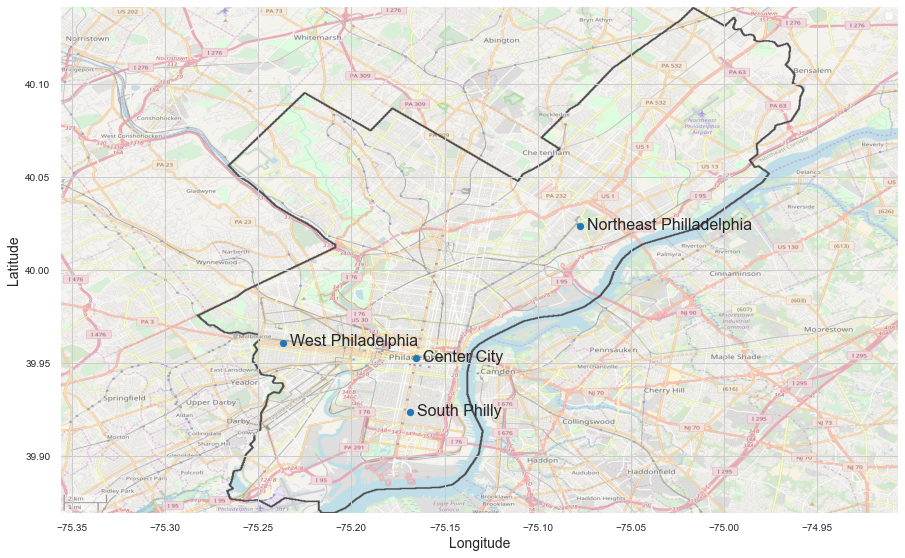

In [224]:
import numpy as np
import matplotlib.image as mpimg
philadelphia_img=mpimg.imread('images/Street_map_of_Philadelphia_and_surrounding_area.png')


plt.axes
plt.figure(figsize=(15,15))
#plt.title('Landmarks Used in Modeling', size=24)
plt.rc('font', size=16)

plt.imshow(philadelphia_img, extent=[-75.356, -74.9066, 39.8694, 40.1414], alpha=0.7)

plt.scatter(lm_lngs, lm_lats)

for i, landmarkname in enumerate(landmarknames):
    plt.annotate(landmarkname, xy=(lm_lngs[i], lm_lats[i]), xytext=(7, -3), textcoords="offset points")

plt.grid('on')
plt.legend()
plt.rc('font', size=18)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.savefig('images/landmarks_map.png',bbox_inches='tight')
plt.show() 

In [64]:
(lat,lng) = landmarks['CC']
lat

39.952583

In [65]:
#create "distance" from center city 
for name in 'CC South West NE'.split():
    (lat, lng) = landmarks[name]
    squared = (df['lat']-lat)**2 + (df['lng']-lng)**2
    df['from' + name] = (squared)**0.5
    df['from' + name + '_Sq'] = squared

In [66]:
df[['fromCC', 'fromCC_Sq', 'fromSouth', 'fromWest', 'fromNE']].head(5)

,fromCC,fromCC_Sq,fromSouth,fromWest,fromNE
0,0.099922,0.009984,0.128048,0.103711,0.110645
1,0.065002,0.004225,0.089776,0.122848,0.049055
2,0.021727,0.000472,0.028429,0.092209,0.107128
3,0.038312,0.001468,0.009269,0.083170,0.141735
4,0.075793,0.005745,0.104909,0.100733,0.084581


In [67]:
df[['from_general_center', 'from_general_center_Sq', 'from_approved_center', 'from_denied_center']].head(5)

,from_general_center,from_general_center_Sq,from_approved_center,from_denied_center
0,115.168881,13263.871057,115.165093,115.176448
1,115.104248,13248.987803,115.100460,115.111815
2,115.130880,13255.119441,115.127092,115.138447
3,115.152180,13260.024453,115.148392,115.159747
4,115.146077,13258.619058,115.142289,115.153644


In [68]:
df['fromCC'].agg(['max','min'])

max    0.252279
min    0.000070
Name: fromCC, dtype: float64

In [69]:
df[['lat','geocode_y']].corr()

,lat,geocode_y
lat,1.000000,0.999754
geocode_y,0.999754,1.000000


In [70]:
df[['lng','geocode_x']].corr()

,lng,geocode_x
lng,1.000000,0.999596
geocode_x,0.999596,1.000000


It appears that geocode_y has strong correlation with latitude as well as geocode_x with longitude. 

In [71]:
try:
    os.mkdir('images')
except:
    print('directory already exists')

directory already exists


In [72]:
df['decision'].unique()

array(['approved', 'other', 'denied'], dtype=object)

### Scatter Plot Map
[(back to the top)](#top)

In [73]:
centers

,lng,lat
decision,,
approved,-75.153301,39.980649
denied,-75.155224,39.992004
general,-75.153759,39.984437


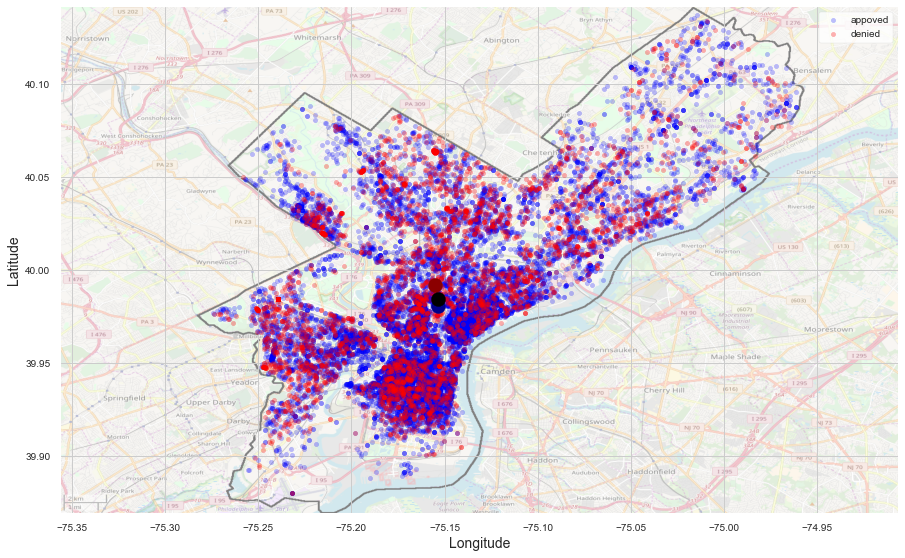

In [225]:
import numpy as np
import matplotlib.image as mpimg
philadelphia_img=mpimg.imread('images/Street_map_of_Philadelphia_and_surrounding_area.png')

plt.axes
plt.figure(figsize=(15,15))
#plt.title('Appeals Map', size=24)
plt.rc('font', size=24)

plt.imshow(philadelphia_img, extent=[-75.356, -74.9066, 39.8694, 40.1414], alpha=0.5)

dfscat = df[df['decision'] == 'approved']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'appoved', s=20, alpha=0.25, c='blue')

dfscat = df[df['decision'] == 'denied']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'denied', s=20, alpha=0.3, c='red')

plt.scatter(centers.loc['denied']['lng'], centers.loc['denied']['lat'], c='darkred', s=200, alpha=1)
plt.scatter(centers.loc['approved']['lng'], centers.loc['approved']['lat'], c='darkblue', s=200, alpha=1)
plt.scatter(centers.loc['general']['lng'], centers.loc['general']['lat'], c='black', s=200, alpha=1)

plt.grid('on')
plt.legend()
plt.rc('font', size=18)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.savefig('images/appeal_map.png',bbox_inches='tight')
plt.show() 

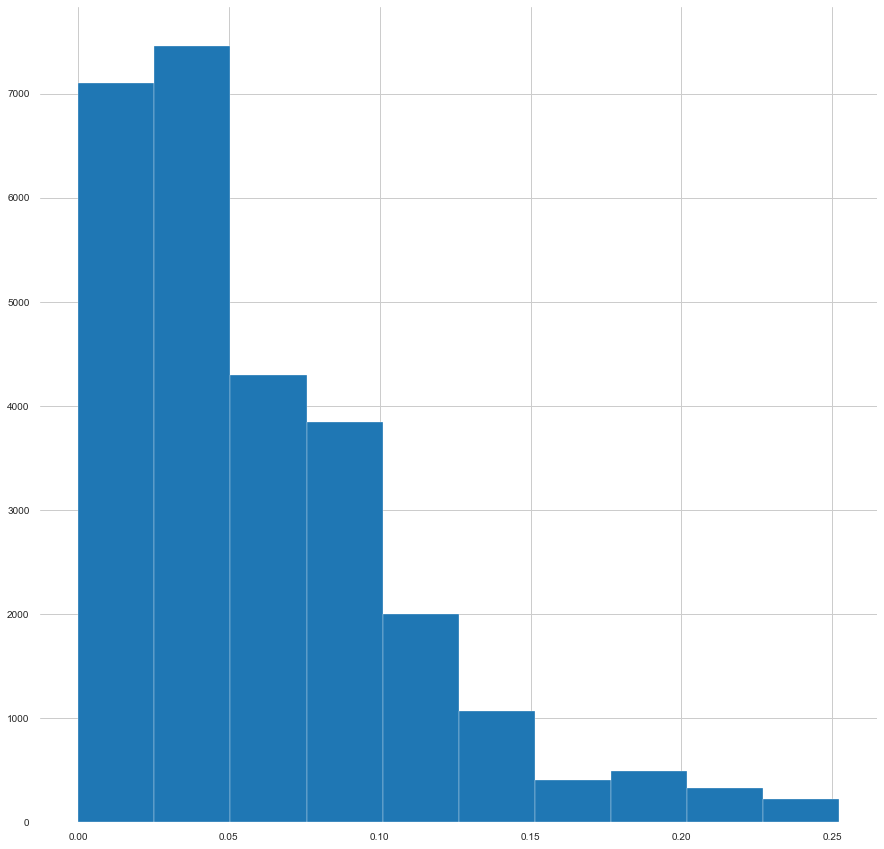

In [226]:
#Distance from CC
plt.figure(figsize=(15,15))
#plt.title('Distances From Center City', size=24)
df['fromCC'].hist()
plt.savefig('images/distances_from_CC.png',bbox_inches='tight')

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

#### Appeal Grounds
[(back to the top)](#top)

In [76]:
df['appealgrounds'] = df['appealgrounds'].str.lower()

In [77]:
#remove punctuation
df['appealgrounds'] = df['appealgrounds'].str.replace(f'[{string.punctuation}]', '')
df['appealgrounds'] = df['appealgrounds'].str.replace('\d+', '')

In [78]:
df[df['appealgrounds'].isna()]['appealgrounds'].shape

(18,)

In [79]:
#dropping 14 records that have null for appealgrounds
df['appealgrounds'].fillna('',inplace=True)

In [80]:
df['appealgrounds'].head(10)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      certificate for preparing and serving of  hot food within an existing retail grocery store and accessory storage nd floor  less than  gross floor area  no signs on this application
1                                                                                                                                                                                                                                           

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

Jump down to  
[Testing Models with TFIDF classifier results](#Testing-Models-with-TFIDF-classifier-results)

### myMetrics Function for model testing
[(back to the top)](#top)

In [81]:
# Create metrics function to check metrics for different models

def myMetrics(model=None, sample=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model'] = model.__class__.__name__
    #print("Model:", model.__class__.__name__)
    hypertablerow['sample'] = sample + ' sample'
    hypertablerow['features'] = features

    X_train_temp = X_train[features]
    X_test_temp = X_test[features]  
    #print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    #print("y_pred_test.value_counts:", pd.Series(y_pred_test).value_counts())
    #print("y_pred_train.value_counts:", pd.Series(y_pred_train).value_counts())

    # F1 score
    hypertablerow['f1_score_test'] = metrics.f1_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('f1_score_test', hypertablerow['f1_score_test'])
    hypertablerow['f1_score_train'] = metrics.f1_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('f1_score_train', hypertablerow['f1_score_train'])
    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    #print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    #print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

### Create "dummy" variables for applicationtype column

In [82]:
# Create "dummy" variables for applicationtype columns
df = pd.concat([df, pd.get_dummies(df['applicationtype'])], axis=1)
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'lawyer', 'decisionsv',
       'provFlag', 'from_approved_center', 'from_approved_center_Sq',
       'from_denied_center', 'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'Board of Building Standards', 'L&I Review Board 

I am planning to oversample and undersample the original dataset.
To be able to compare the results of the original dataset with oversample and undersample I am creating two sets for the X and y as well as the list of sample names.

In [83]:
X = {}
y = {}
samples = ['original', 'under', 'over']

In [84]:
# Declare an explanatory variable, and assign some data to it 
X['original'] = df.drop(['decision'], axis=1)

# Declare a response variable, the decision column of the df 
y['original'] = df['decision'] 

In [85]:
X['original'].columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'meetingresult',
       'proviso', 'decisiondate', 'systemofrecord', 'geocode_x', 'geocode_y',
       'lat', 'lng', 'lawyer', 'decisionsv', 'provFlag',
       'from_approved_center', 'from_approved_center_Sq', 'from_denied_center',
       'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'Board of Building Standards', 'L&I Review Board Codes',
    

### Pre-processing and Test/Train Split
[(back to the top)](#top)

In [86]:
#UnderSampling

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X['original'], y['original'])

X['under'], y['under'] = rus.fit_resample(X['original'], y['original'])

In [87]:
#OverSampling

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X['original'], y['original'])

X['over'], y['over'] = ros.fit_resample(X['original'], y['original'])

In [88]:
# import the preprocessing package
from sklearn import preprocessing
X_train = {}
X_test = {}
y_train = {}
y_test = {}

# Call the train_test_split() function
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
for sample in samples:
    X_train[sample], X_test[sample], y_train[sample], y_test[sample] = \
    train_test_split(X[sample], y[sample], test_size=0.25, random_state=1)

In [89]:
for sample in samples:
    print('\n' + sample + ' sample')
    print('X_train.shape',X_train[sample].shape)
    print('X_test.shape',X_test[sample].shape)
    print('y_train.size', y_train[sample].size)
    print('y_test.size', y_test[sample].size)
    print('y_train.value_counts',y_train[sample].value_counts())
    print('y_train.describe', y_test[sample].value_counts())


original sample
X_train.shape (20418, 56)
X_test.shape (6806, 56)
y_train.size 20418
y_test.size 6806
y_train.value_counts approved    12638
other        4668
denied       3112
Name: decision, dtype: int64
y_train.describe approved    4288
other       1475
denied      1043
Name: decision, dtype: int64

under sample
X_train.shape (9348, 56)
X_test.shape (3117, 56)
y_train.size 9348
y_test.size 3117
y_train.value_counts denied      3141
other       3112
approved    3095
Name: decision, dtype: int64
y_train.describe approved    1060
other       1043
denied      1014
Name: decision, dtype: int64

over sample
X_train.shape (38083, 56)
X_test.shape (12695, 56)
y_train.size 38083
y_test.size 12695
y_train.value_counts denied      12729
other       12692
approved    12662
Name: decision, dtype: int64
y_train.describe approved    4264
other       4234
denied      4197
Name: decision, dtype: int64


### Testing LinearSVC model

In [90]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#model = GaussianNB()
#model = KNeighborsClassifier(n_neighbors=10)
model = svm.LinearSVC() # Linear Kernel
#model = svm.SVC(kernel='poly') # Linear Kernel
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    print('y_true_test.value_counts()', y_true_test.value_counts())

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'fromCC']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4288
other       1475
denied      1043
Name: decision, dtype: int64
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    5452
other       1354
dtype: int64
y_pred_train.describe: approved    16184
other        4234
dtype: int64
Test Accuracy 0.7490449603291214
Train Accuracy 0.7446860613184445
y_true_test.value_counts() approved    1060
other       1043
denied      1014
Name: decision, dtype: int64
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    1997
other       1120
dtype: int64
y_pred_train.describe: approved    5971
other       3377
dtype: int64
Test Accuracy 0.5203721527109401
Train Accuracy 0.5157252888318357
y_true_test.value_counts() approved    4264
other       4234
denied      4197
Na

In [91]:
model = svm.LinearSVC() # Linear Kernel
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

y_true_train = y_train['over']
y_true_test = y_test['over']

X_train_temp = X_train['over'][features]
X_test_temp = X_test['over'][features]  

#    print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_pred_test.describe: denied      9985
approved    2290
other        420
dtype: int64
y_pred_train.describe: denied      29921
approved     6898
other        1264
dtype: int64
Test Accuracy 0.40504135486411974
Train Accuracy 0.4070057505973794


In [92]:
from sklearn.metrics import confusion_matrix

In [93]:
np.set_printoptions(precision=2)

cm = confusion_matrix(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)


In [94]:
cm

array([[1346, 2918,    0],
       [ 469, 3552,  176],
       [ 475, 3515,  244]], dtype=int64)

In [95]:
y_true_test.value_counts()

approved    4264
other       4234
denied      4197
Name: decision, dtype: int64

In [96]:
pd.Series(y_pred_test).value_counts()

denied      9985
approved    2290
other        420
dtype: int64

It appears that Linear SVC model even when oversampled returns very poor test result - no values in "denied" class.

### Testing KNeighborsClassifier model

In [97]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier(n_neighbors=10)
#model = svm.LinearSVC() # Linear Kernel
model = svm.SVC(kernel='poly', degree=2) # Poy Kernel - takes VERY LONG time
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    print('y_true_test.value_counts()', y_true_test.value_counts())

    print("Model:", model.__class__.__name__)

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'fromCC']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4288
other       1475
denied      1043
Name: decision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    5452
other       1354
dtype: int64
y_pred_train.describe: approved    16184
other        4234
dtype: int64
Test Accuracy 0.7490449603291214
Train Accuracy 0.7446860613184445
y_true_test.value_counts() approved    1060
other       1043
denied      1014
Name: decision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    1997
other       1120
dtype: int64
y_pred_train.describe: approved    5971
other       3377
dtype: int64
Test Accuracy 0.5203721527109401
Train Accuracy 0.5157252888318357
y_true_test.value_counts() approved    4264
other       42

### Confusion Matrix

In [98]:
y_true_test.value_counts()

approved    4264
other       4234
denied      4197
Name: decision, dtype: int64

Confusion matrix, without normalization
[[   0 4221   43]
 [   0 4168   29]
 [   0 4196   38]]
Normalized confusion matrix
[[0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]]


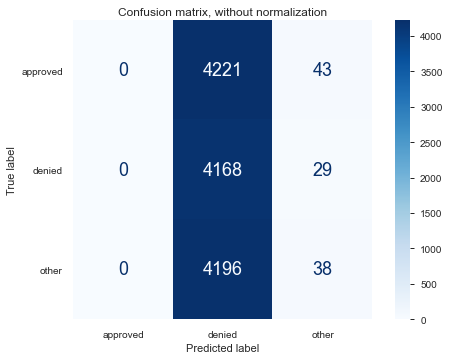

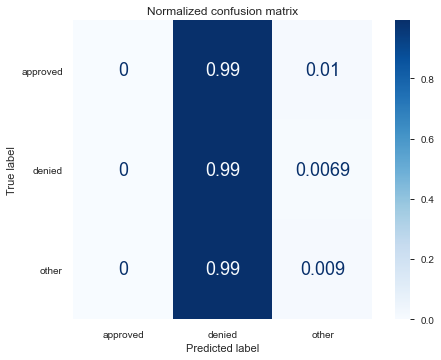

In [99]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test_temp, y_true_test,
#                                 display_labels=y_true_test.sort_values().unique(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


### LogisticRegression
[(back to the top)](#top)

In [100]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [101]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [102]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [103]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [104]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [105]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [106]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [107]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [108]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### KNeighborsClassifier Model

In [109]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [110]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [111]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [112]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [113]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [114]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [115]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [116]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [117]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Gaussian Naive Bayes Model

In [118]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [119]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [120]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [121]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [122]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [123]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Random Forrest Classifier Model

In [124]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [125]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [126]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [127]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Decision Tree Classifier

In [128]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, random_state = 1234)

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [129]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

## Final Hypertable
[(back to the top)](#top)

In [130]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable = pd.DataFrame(hypertable).sort_values('precision_test')
pd.set_option('display.max_colwidth', -1)
pd.set_option("max_rows", None)
dfhypertable.round(3).sort_values('f1_score_test', ascending=False)

,model,sample,features,f1_score_test,f1_score_train,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train
45,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.708,0.735,0.742,0.765,0.707,0.744,0.742,0.765
42,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.707,0.735,0.742,0.764,0.706,0.743,0.742,0.764
39,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.707,0.735,0.741,0.765,0.706,0.744,0.741,0.765
48,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.706,0.734,0.741,0.764,0.705,0.743,0.741,0.764
33,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC]",0.705,0.731,0.743,0.763,0.706,0.742,0.743,0.763
36,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.705,0.734,0.740,0.764,0.704,0.743,0.740,0.764
51,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center, from_approved_center_Sq, from_denied_center_Sq]",0.698,0.733,0.737,0.763,0.696,0.743,0.737,0.763
12,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.695,0.691,0.740,0.735,0.692,0.690,0.740,0.735
18,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.693,0.687,0.736,0.730,0.696,0.693,0.736,0.730
15,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.692,0.687,0.735,0.730,0.696,0.693,0.735,0.730


## Testing Models with TFIDF classifier results
[(back to the top)](#top)

##### Configure and run TFIDF

In [131]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), 
                    max_df=0.75, min_df=15)
tfidfmatrix = vectorizer.fit_transform(df['appealgrounds'])
type(tfidfmatrix)

scipy.sparse.csr.csr_matrix

In [132]:
#tfidfmatrix = tfidfmatrix.todense()
tfidfmatrix = tfidfmatrix.toarray()
type(tfidfmatrix)

numpy.ndarray

In [133]:
type(vectorizer.get_feature_names())

list

In [134]:
df_tfidf = pd.DataFrame(tfidfmatrix, columns=vectorizer.get_feature_names())
df_tfidf.head()

,ab,abandoned,able,abutting,ac,acc,acc parking,acc parking spaces,acc storage,access,...,zoning district use,zoning lot,zoning lot treatment,zoning lots,zoning permit,zoning purposes,zoning purposes restrictive,zoning use,zoninguse,zoninguse permit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
df_tfidf.shape

(27224, 8162)

In [136]:
final_features = ['decision', 'Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', \
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', \
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']

In [137]:
df_final_features = df[final_features].rename(columns={'decision':'_decision_', 'lawyer':'_lawyer_'})
df_final_features.reset_index(inplace=True)
df_final_features.columns

Index(['index', '_decision_', 'Board of Building Standards',
       'L&I Review Board Codes', 'Zoning Board of Adjustment', '_lawyer_',
       'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
       'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq'],
      dtype='object')

In [138]:
df_final_features.shape

(27224, 15)

In [139]:
df_tfidf.shape
#df_tfidf.reset_index(inplace=True)

(27224, 8162)

In [140]:
appealgrounds_df = pd.concat([df_final_features, df_tfidf], axis=1)
appealgrounds_df.shape

(27224, 8177)

In [141]:
appealgrounds_df.columns[:20]

Index(['index', '_decision_', 'Board of Building Standards',
       'L&I Review Board Codes', 'Zoning Board of Adjustment', '_lawyer_',
       'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
       'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 'ab',
       'abandoned', 'able', 'abutting', 'ac'],
      dtype='object')

In [142]:
onerow = appealgrounds_df.iloc[150]
onerow = onerow[(onerow.notna())]
type(onerow)

pandas.core.series.Series

In [143]:
onerow[onerow != 0]

index                         154       
_decision_                    approved  
Zoning Board of Adjustment    1         
_lawyer_                      1         
fromCC                        0.0560694 
from_general_center           115.115   
fromSouth                     0.0822559 
fromWest                      0.111924  
fromNE                        0.0596485 
fromCC_Sq                     0.00314378
fromSouth_Sq                  0.00676602
fromWest_Sq                   0.012527  
fromNE_Sq                     0.00355794
accessory                     0.174467  
accessory offices             0.214453  
building                      0.198495  
classrooms                    0.239931  
employee                      0.275083  
existing                      0.0608171 
existing story                0.12337   
existing story structure      0.14564   
floor                         0.164066  
floor accessory               0.19183   
floor existing                0.137075  
floor existing s

In [144]:
df['appealgrounds'].iloc[150]

'permit for a warehouse for storage of building maintenance supplies with accessory offices and employee breakroom on the first floor and for accessory classrooms for training in building maintenance on the second floor of an existing two  story structure\r\n\r\n\r\n\r\n'

##### Testing models with TFIDF vectorizer results

In [145]:
# Create metrics function to check metrics for different models

def myMetrics2(model=None, sample=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model'] = model.__class__.__name__
    hypertablerow['sample'] = sample
    hypertablerow['features'] = features

    X_train_temp = X_train
    X_test_temp = X_test
    #print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    #print("y_pred_test.value_counts:", pd.Series(y_pred_test).value_counts())
    #print("y_pred_train.value_counts:", pd.Series(y_pred_train).value_counts())

    # F1 score
    hypertablerow['f1_score_test'] = metrics.f1_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('f1_score_test', hypertablerow['f1_score_test'])
    hypertablerow['f1_score_train'] = metrics.f1_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('f1_score_train', hypertablerow['f1_score_train'])
    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    #print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    #print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

In [146]:
appealgrounds_df.fillna(value=0, inplace=True)

In [147]:
appealgrounds_df.shape

(27224, 8177)

In [148]:
# Declare a response variable, the decision column of the df 
y = appealgrounds_df['_decision_'] 

# Declare an explanatory variable, and assign some data to it 
X = appealgrounds_df.drop(['_decision_'], axis = 1)

In [149]:
onerow = X.iloc[150]
onerow = onerow[(onerow.notna())]
onerow[onerow != 0]

index                         154.000000
Zoning Board of Adjustment    1.000000  
_lawyer_                      1.000000  
fromCC                        0.056069  
from_general_center           115.114927
fromSouth                     0.082256  
fromWest                      0.111924  
fromNE                        0.059648  
fromCC_Sq                     0.003144  
fromSouth_Sq                  0.006766  
fromWest_Sq                   0.012527  
fromNE_Sq                     0.003558  
accessory                     0.174467  
accessory offices             0.214453  
building                      0.198495  
classrooms                    0.239931  
employee                      0.275083  
existing                      0.060817  
existing story                0.123370  
existing story structure      0.145640  
floor                         0.164066  
floor accessory               0.191830  
floor existing                0.137075  
floor existing story          0.209071  
maintenance     

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [151]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']


In [152]:
model = KNeighborsClassifier(n_neighbors=10)

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [153]:
model = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, random_state = 1234)

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [154]:
model = RandomForestClassifier(max_depth= 10, random_state= 1234)

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [155]:
model = GaussianNB()

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [156]:
model = LogisticRegression(class_weight='balanced')

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [157]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable = pd.DataFrame(hypertable).sort_values('precision_test')
pd.set_option('display.max_colwidth', -1)
pd.set_option("max_rows", None)
dfhypertable.round(3).sort_values('f1_score_test', ascending=False)

,model,sample,features,f1_score_test,f1_score_train,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train
45,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.708,0.735,0.742,0.765,0.707,0.744,0.742,0.765
91,DecisionTreeClassifier,TFIDF Vectorizer,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.707,0.709,0.756,0.757,0.722,0.734,0.756,0.757
42,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.707,0.735,0.742,0.764,0.706,0.743,0.742,0.764
39,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.707,0.735,0.741,0.765,0.706,0.744,0.741,0.765
48,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.706,0.734,0.741,0.764,0.705,0.743,0.741,0.764
33,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC]",0.705,0.731,0.743,0.763,0.706,0.742,0.743,0.763
36,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.705,0.734,0.740,0.764,0.704,0.743,0.740,0.764
51,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center, from_approved_center_Sq, from_denied_center_Sq]",0.698,0.733,0.737,0.763,0.696,0.743,0.737,0.763
12,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.695,0.691,0.740,0.735,0.692,0.690,0.740,0.735
18,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.693,0.687,0.736,0.730,0.696,0.693,0.736,0.730


Back to  
[Configure and run TFIDF](#Configure-and-run-TFIDF)